# Polynominal regression analysis on file.csv

In this notebook we will analyise the data further by performing a polynominal fit on the number of sales per day per item. We will make a code that can find patterns in sales behaviour. 

We will first start with applying the fit and then substract this fit from the real data. After that we will make a cosine similarity matrix and then perform k-means clustering to find different types of product categories. 

This code is an adaptation and combination to the other codes used to visualize the data. 

**imports**

We use the standard scientific analysis libraries numpy, pyplot, pandas and scipy. We also used the sklearn library for the k-means clustering.

**file definitions**

We define the filename and column names of interest to make it easier to apply this notebook to other datasets.

**analysis settings**

Lastly we define our variables for the number of days to use for our roling average and the number of components of the fourier anlysis we expect to be trend related.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import kstest, zscore
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.ticker import MaxNLocator

FILENAME = "data/file.csv"
DATE_COLUMN_NAME = "Transaction_Date"
CATEGORY_COLUMN_NAME = "Product_Category"
FOURIER_COMPONENTS = 30


First we read in the data of the sales numbers per day using a pandas crosstab.

One thing this misses is that some transactions may have more then one of the item contained in them. Beacause some of our datasets have this field and some don't we decided to look at the number of transaclions and not the number of items sold.

The data is for one year from 2019-01-01 up to and including 2019-12-31

In [2]:
def read_csv(filename: str) -> tuple[list, list[list]]:
    """
    Read in a csv file into an array.

    This function returns the headers, the dataset and the dataset in the form of a dataframe.
    """
    pd_dataset = pd.read_csv(filename, low_memory=False)
    headers = pd_dataset.columns.to_list()
    dataset = pd_dataset.to_numpy()
    return headers, dataset, pd_dataset

In [3]:
headers, dataset, pd_dataset = read_csv("data/file.csv")
data_labels = pd_dataset['Product_Category'].unique().tolist()

Now that we have the data, we will visualize the data and make a plot of the total items bought vs the dates. We can then perform a polynominal fit on this data.

In [4]:
def polynomial_regression(x, y, degree):
    '''
    This function uses the numpy polyfit function to perform a polynominal fit. 
    '''
    coeffs = np.polyfit(x, y, degree)
    poly_func = np.poly1d(coeffs)
    predictions = poly_func(x)
    return poly_func, predictions

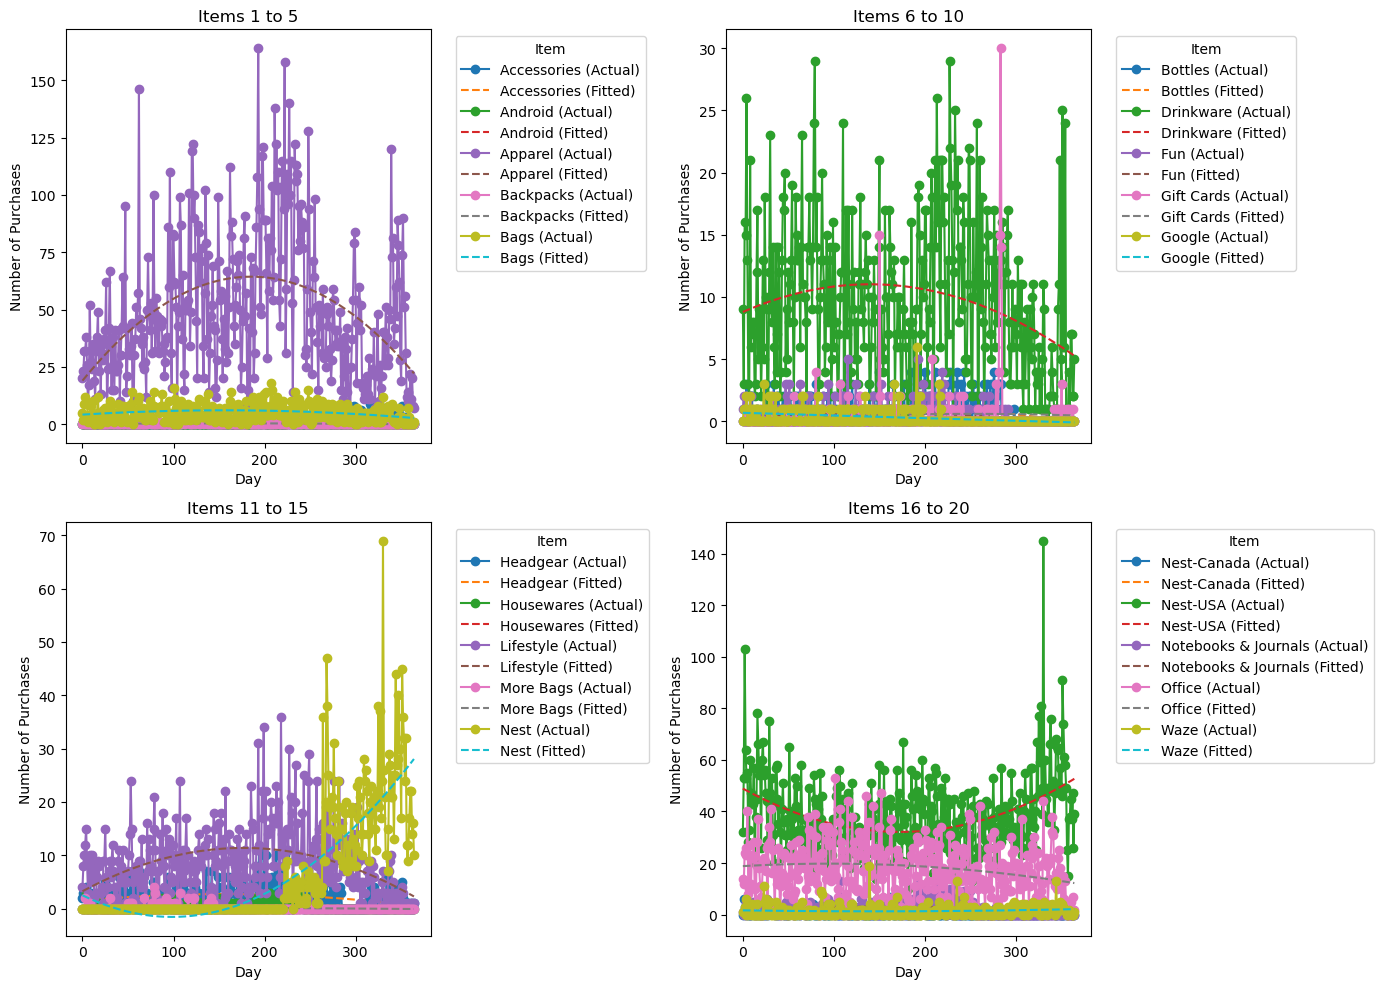

In [5]:
# extract the right columns and put in a list
column_id = [6,9] # the entries of the data 

data_date = [entry[column_id[0]] for entry in dataset]
data_item = [entry[column_id[1]] for entry in dataset]

# make a dataframe from the two lists with data
df = pd.DataFrame({'Date': data_date, 'Item': data_item})
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.to_period('D')    # sort data per day

# sort the dataframe
item_purchases_over_time = (df.groupby(['Day', 'Item']).size().reset_index(name='Total_Purchases'))
pivot_data = item_purchases_over_time.pivot(index='Day', columns='Item', values='Total_Purchases').fillna(0)

# split the items in groups/chunks for plotting
items = pivot_data.columns.to_list()
chunks = [items[:5], items[5:10], items[10:15], items[15:]]

# make labels and numeric time
x_labels = pivot_data.index.to_timestamp().strftime('%Y-%m-%d')
numeric_time = range(len(x_labels))


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# for loop that loops over each chunk and performs polynominal fit
data_predicted = {}
real_data = {}
for i, chunk in enumerate(chunks):
    ax = axes[i]
    for item in chunk:
        ax.plot(numeric_time, pivot_data[item].values, marker='o', label=f'{item} (Actual)')
        real_data[item] = pivot_data[item].values
        if pivot_data[item].sum() > 0:
            poly_func, predictions = polynomial_regression(numeric_time, pivot_data[item].values, degree=2)
            ax.plot(numeric_time, predictions, linestyle='--', label=f'{item} (Fitted)')
            data_predicted[item]= predictions
    
    ax.set_title(f'Items {i * 5 + 1} to {i * 5 + len(chunk)}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Number of Purchases')
    ax.set_xticks(numeric_time)
    ax.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    
plt.tight_layout()
plt.show()

We see that our original data is very noisy, but the polynomal fit does fit on each item. We can now further analyse this data by substracting the fitted data from the real data. These new datapoints can then be use to make a similarity matrix and perform a k-mean cluster. But first, let's plot the corrected datapoints. The functions below are copied from the fourier analysis, this will give use the real data for our new analysis.

In [6]:
def rolling_average(nr_days):
    # read in the data
    df = pd.read_csv(FILENAME, parse_dates=[DATE_COLUMN_NAME])
    # aggregate by date
    df_per_day = pd.crosstab(df[DATE_COLUMN_NAME].dt.date,
                             df[CATEGORY_COLUMN_NAME])
    # sort for certainty
    df_per_day = df_per_day.sort_index()
    # get roling average
    df_rolling_avg = df_per_day.rolling(window=nr_days,
                                        center=True,
                                        min_periods=1).mean()
    df_rolling_avg = df_rolling_avg.dropna()
    # plotting
    df_rolling_avg.plot.line(ax=plt.gca())
    plt.xlabel("Date")
    plt.ylabel("Sales_Number")
    plt.title(f"roling average of sales for surrounding {nr_days} days")
    plt.show()

def fourier_fit(nr_days=1):
    # read in the data
    df = pd.read_csv(FILENAME, parse_dates=[DATE_COLUMN_NAME])
    # aggregate by date
    df_per_day = pd.crosstab(df[DATE_COLUMN_NAME].dt.date,
                             df[CATEGORY_COLUMN_NAME])
    # sort for certainty
    df_per_day = df_per_day.sort_index()
    # get roling average
    df_rolling_avg = df_per_day.rolling(window=nr_days,
                                        center=True,
                                        min_periods=1).mean()
    df_rolling_avg = df_rolling_avg.dropna()
    # convert to numpy for use of np.fft
    column_names = df_rolling_avg.columns.tolist()
    real_data = df_rolling_avg.to_numpy()

    # save the fourier analysis values
    fourier_values = []
    real_data_dict = {}
    for x in range(5):
        for y in range(4):
            index = x * 4 + y
            # make a fourier fit

            real_data_dict[column_names[index]] = real_data.T[index]
            fft_analysis = np.fft.fft(real_data.T[index])
            fft_analysis_truncated = np.zeros_like(fft_analysis)
            fft_analysis_truncated[:FOURIER_COMPONENTS] = fft_analysis[:FOURIER_COMPONENTS]
            fourier_values.append(fft_analysis[:FOURIER_COMPONENTS])
            reconstructed_data = np.fft.ifft(fft_analysis_truncated).real

    return real_data_dict

In [7]:
real_data = fourier_fit(14)

The function below is used to correct the trend

In [8]:
def trend_correction(real_data, fitted_data, nr_days=1):
    corrected_data = {}
    for key ,value in real_data.items():
        corrected_data[key] = real_data[key] - fitted_data[key] 

    keys = list(corrected_data.keys())
    data_values = list(corrected_data.values())

    df = pd.read_csv(FILENAME, parse_dates=[DATE_COLUMN_NAME])
    # aggregate by date
    df_per_day = pd.crosstab(df[DATE_COLUMN_NAME].dt.date,
                             df[CATEGORY_COLUMN_NAME])
    # sort for certainty
    df_per_day = df_per_day.sort_index()
    # get roling average
    df_rolling_avg = df_per_day.rolling(window=nr_days,
                                        center=True,
                                        min_periods=1).mean()
    df_rolling_avg = df_rolling_avg.dropna()
    column_names = df_rolling_avg.columns.tolist()
    big_fig, figs = plt.subplots(5, 4, figsize=(20,16))

    fourier_values = []
    index = -1
    for x in range(5):
        for y in range(4):
            index += 1
            figs[x, y].plot(df_rolling_avg.index, data_values[index],
                            label="Trend Corrected Data")
            figs[x, y].set_ylabel("Sales Number Corrected")
            figs[x, y].set_title(keys[index])
            figs[x, y].tick_params(axis='x', rotation=45)
    big_fig.align_labels()
    plt.tight_layout()
    big_fig.subplots_adjust(top=0.88, wspace=0.4, hspace=0.6)
    plt.legend()
    plt.show()
    return corrected_data


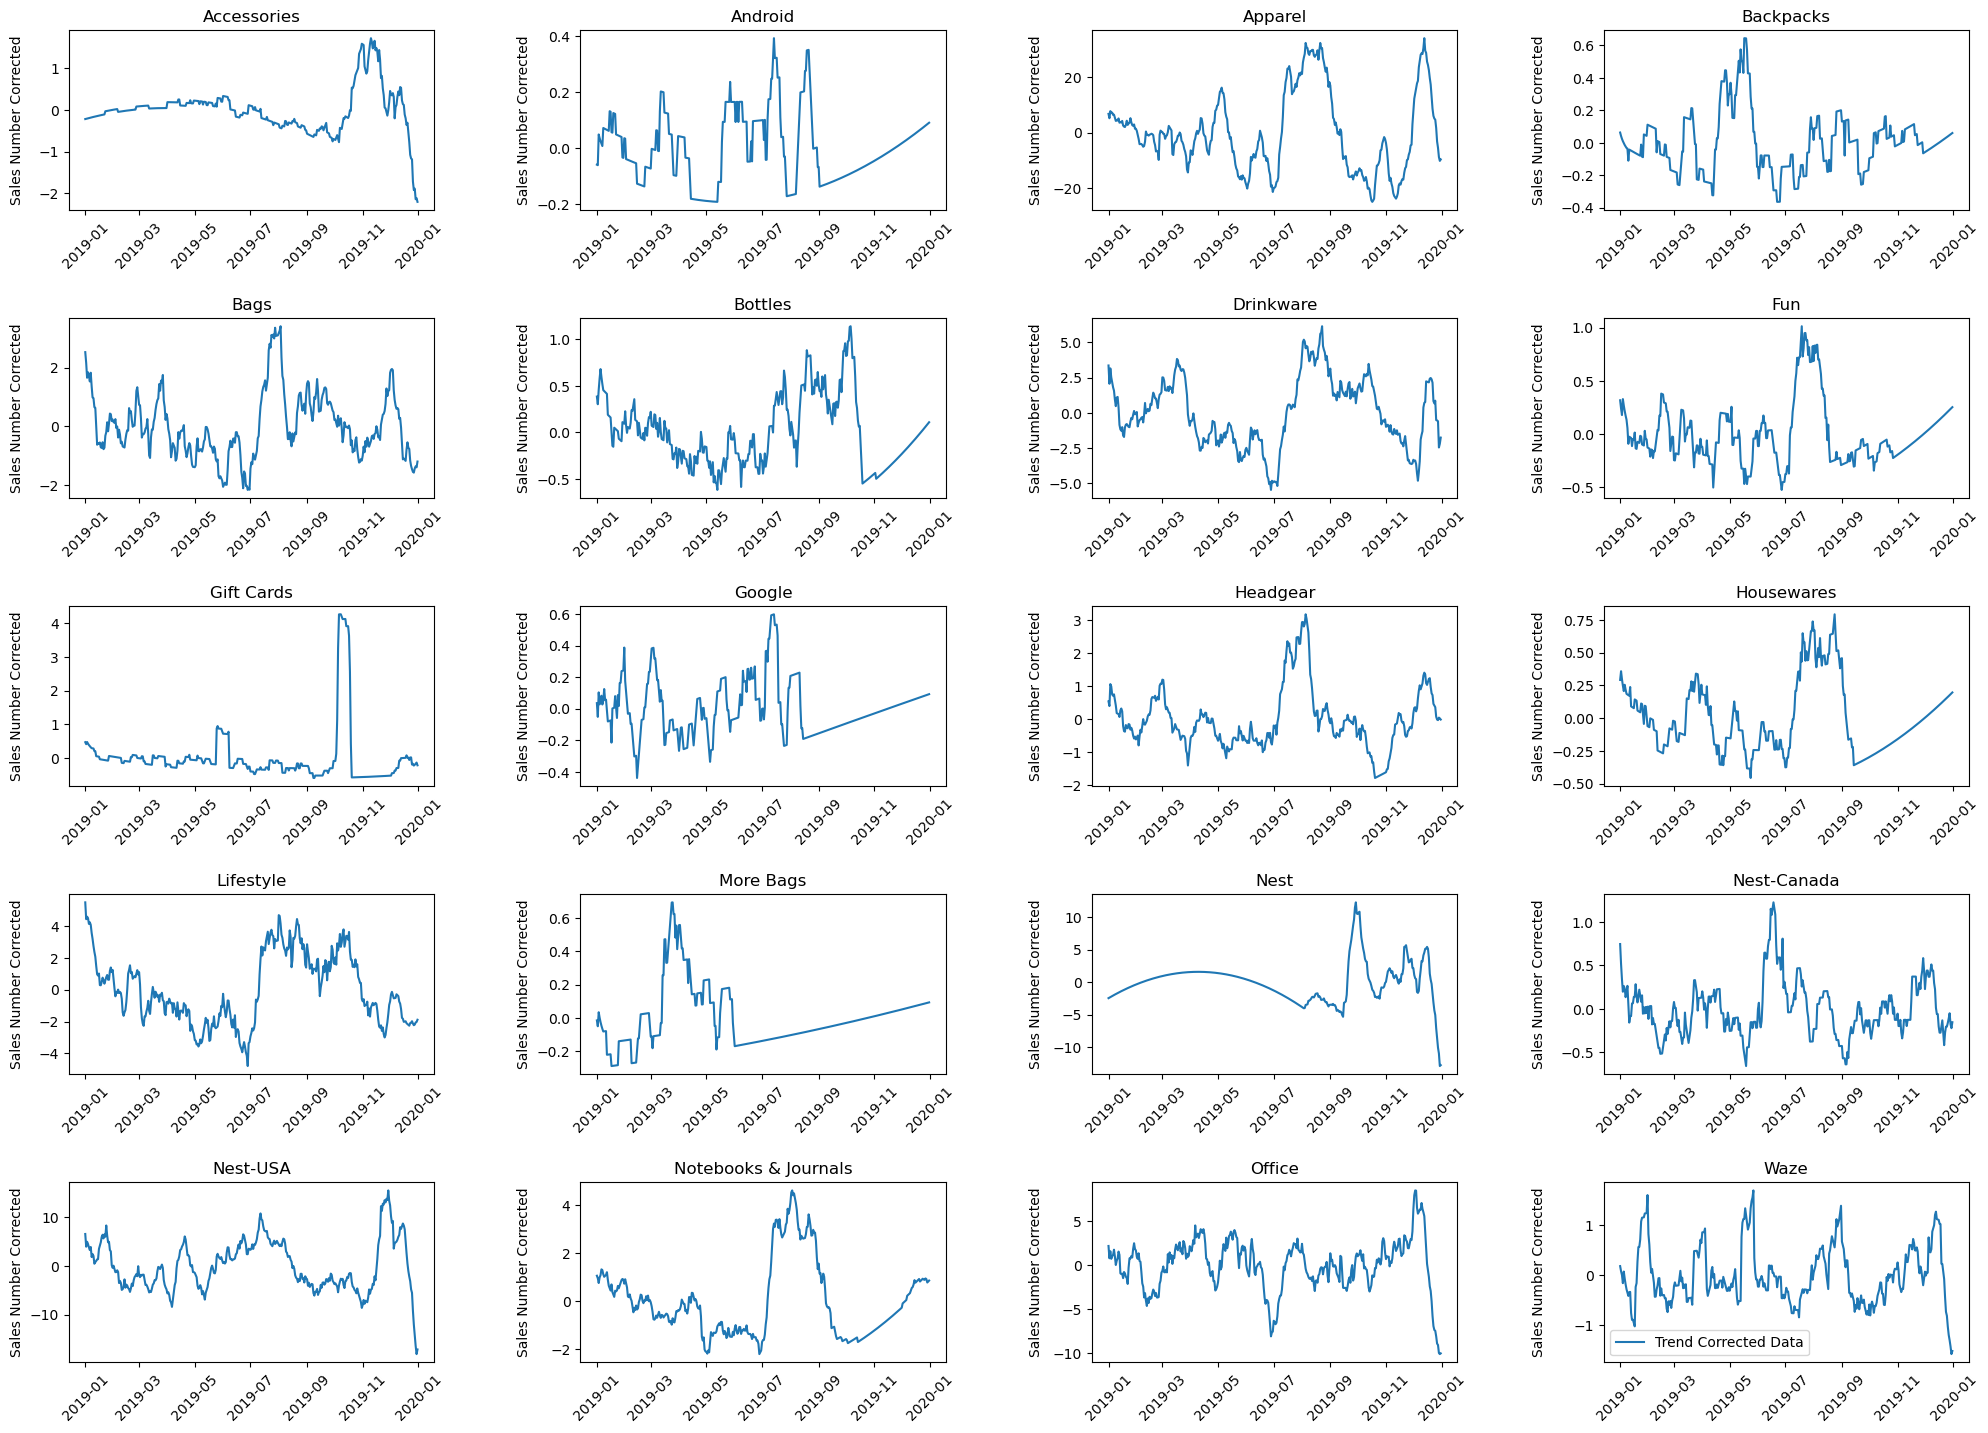

In [9]:
corrected_data = trend_correction(real_data, data_predicted, 14)

We see  that there are now small positive and negative differences between the real data and the fitted data. If the line is zero, it means that our fitted data matches the real data. Hence, if the curve is close to zero with small positve and negative fluctuations, it means that our fitting type is accurate. 

Now we can use this data to make a cosine similarity matrix and perform the k-means clustering analysis.

In [10]:
def cosine_similarity(vec_1, vec_2):
    dot_product = np.dot(vec_1, vec_2)

    magnitude1 = np.linalg.norm(vec_1)
    magnitude2 = np.linalg.norm(vec_2)
    return dot_product / (magnitude1*magnitude2)

def cosine_sim_matrix(corrected_data):
    x, y = len(corrected_data), len(corrected_data)
    cosine_similarity_matrix = np.zeros((x, y))
    keys = list(corrected_data.keys())
    data_values = list(corrected_data.values())

    for i in range(len(corrected_data)):
        for j in range(len(corrected_data)):
            cosine_similarity_matrix[i, j] = cosine_similarity(data_values[i], data_values[j])
            

    return cosine_similarity_matrix, keys

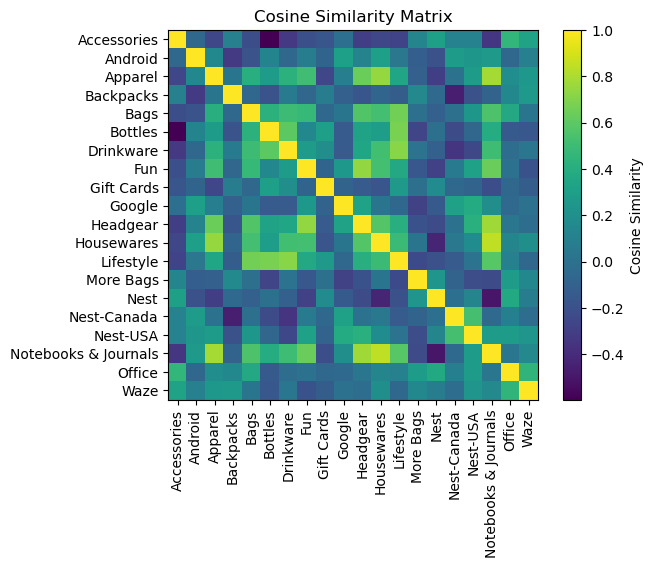

In [11]:
cosine_similarity_matrix, keys = cosine_sim_matrix(corrected_data)
plt.imshow(cosine_similarity_matrix)
plt.xticks(range(len(keys)), keys, rotation=90)
plt.yticks(range(len(keys)), keys)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Matrix')
plt.show()

We can clearly see that some trends are related to eachother and some are very different. For example, we see that the item "Accesories" does not have a lot of similarities with the other items, but the item "Notebooks & Journals" have a lot more similarities.

In [12]:
def kmeans_clustering(similarity_matrix, n_clusters):
    pca = PCA(n_components=2)
    points_2d = pca.fit_transform(similarity_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points_2d)
    centers = kmeans.cluster_centers_
    return labels, centers, points_2d

def visualize_clusters(points, labels, centers, n_clusters, data_labels):
    plt.figure(figsize=(10, 8))
    for i in range(n_clusters):
        cluster_points = points[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', marker='X', label='Centers')
    for idx, (x, y) in enumerate(points):
        plt.text(x, y, data_labels[idx], fontsize=9, alpha=0.8, ha='right', va='bottom')

    plt.title('K-means Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

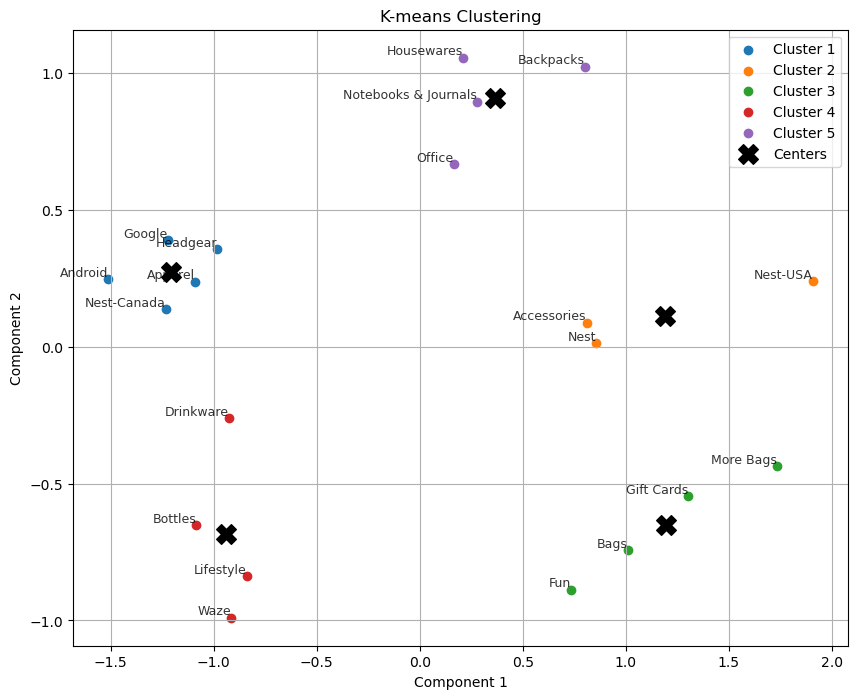

In [13]:
n_clusters = 5
labels, centers, points_2d = kmeans_clustering(cosine_similarity_matrix, n_clusters)
visualize_clusters(points_2d, labels, centers, n_clusters, data_labels)

Above is the final cluster-plot. We see that there are 5 clusters in total, hence we set the variable n_clusters to 5 in our code. We can now use this plot to compare it with the fourier analyis and check if the results mach.

In [14]:
for i in range(n_clusters):
    print(np.array(data_labels)[:20][labels == i])

['Apparel' 'Headgear' 'Google' 'Nest-Canada' 'Android']
['Nest-USA' 'Nest' 'Accessories']
['Bags' 'Fun' 'Gift Cards' 'More Bags']
['Drinkware' 'Lifestyle' 'Waze' 'Bottles']
['Office' 'Notebooks & Journals' 'Backpacks' 'Housewares']


Finally, we perform a Kolmogorov-Smirnov test on residuals of each category to check if they follow a normal distribution. Output includes the total number of categories, the count of passed/failed tests, and their respective names.

In [ ]:
# calculate polynomial residuals
polynomial_residuals = {}
for key, observed in real_data.items():
    predicted = data_predicted[key]
    residuals = observed - predicted
    polynomial_residuals[key] = residuals

# KS test for polynomial residuals
print("KS test for polynomial residuals:")
passed_categories = []
failed_categories = []

for category, residual in polynomial_residuals.items():
    standardized_residual = zscore(residual)
    _, p_value = kstest(standardized_residual, 'norm')
    
    if p_value > 0.05:
        passed_categories.append(category)
    else:
        failed_categories.append(category)

# print summary
print(f"Total categories: {len(polynomial_residuals)}")
print(f"categories passing KS test (p > 0.05): {len(passed_categories)}")
print(f"categories failing KS test (p ≤ 0.05): {len(failed_categories)}")
print("passed Categories:", passed_categories)
print("failed Categories:", failed_categories)

KS test for polynomial residuals:
Total categories: 20
categories passing KS test (p > 0.05): 3
categories failing KS test (p ≤ 0.05): 17
passed Categories: ['Android', 'Drinkware', 'Office']
failed Categories: ['Accessories', 'Apparel', 'Backpacks', 'Bags', 'Bottles', 'Fun', 'Gift Cards', 'Google', 'Headgear', 'Housewares', 'Lifestyle', 'More Bags', 'Nest', 'Nest-Canada', 'Nest-USA', 'Notebooks & Journals', 'Waze']
